In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

In [2]:
physical_devices = torch.cuda.get_device_name(0)
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

Tesla T4


'cuda'

In [3]:
# ratings_df = pd.read_csv('../data/jester_ratings.csv')
# jokes_df = pd.read_csv('../data/jester_items.csv')
jokes_df = pd.read_csv('/kaggle/input/jester-17m-jokes-ratings-dataset/jester_items.csv')
ratings_df = pd.read_csv('/kaggle/input/jester-17m-jokes-ratings-dataset/jester_ratings.csv')
display(ratings_df[:5]), display(jokes_df[:5])

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,4,Q. What's the difference between a man and a t...
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...


(None, None)

In [4]:
df = ratings_df 

In [5]:
df['userId'] = df['userId'].astype('category').cat.codes.values
df['jokeId'] = df['jokeId'].astype('category').cat.codes.values

In [6]:
display(df.head(4))

,userId,jokeId,rating
0,0,0,0.219
1,0,1,-9.281
2,0,2,-9.281
3,0,3,-6.781


In [8]:
# Splitting dataset into train and test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=1)
train_data.shape, test_data.shape

((1233007, 3), (528432, 3))

In [9]:
num_users = ratings_df['userId'].nunique()
num_jokes = ratings_df['jokeId'].nunique()
num_users, num_jokes

(59132, 140)

![](neuralCF_architecture.png)

In [10]:
class NeuralCollaborative(nn.Module):
    def __init__(self, num_users, num_jokes, embedding_dim=256):
        super(NeuralCollaborative, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.joke_embedding = nn.Embedding(num_jokes, embedding_dim)

        # layers
        self.fc1 = nn.Linear(embedding_dim*2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1) # single value of prediction rating

    def forward(self, user_id, joke_id):
        user_embedding = self.user_embedding(user_id)
        joke_embedding = self.joke_embedding(joke_id)

        # concatenate user and joke embeddings
        x = torch.cat([user_embedding, joke_embedding], dim=1)

        # through the fully connected layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = self.fc4(x)
        return output 

In [11]:
embedding_dim = 256

In [25]:
model = NeuralCollaborative(num_users, num_jokes, embedding_dim)
model = torch.nn.DataParallel(model, device_ids=[0,1])
model.to(device)

DataParallel(
  (module): NeuralCollaborative(
    (user_embedding): Embedding(59132, 256)
    (joke_embedding): Embedding(140, 256)
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [27]:
# Prepare the training data
train_user_ids = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_joke_ids = torch.tensor(train_data['jokeId'].values, dtype=torch.long).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32).to(device)
train_user_ids.shape, train_joke_ids.shape, train_ratings.shape 

(torch.Size([1233007]), torch.Size([1233007]), torch.Size([1233007]))

Using batch size for faster training

In [28]:
train_dataset = torch.utils.data.TensorDataset(train_user_ids, train_joke_ids, train_ratings)
batch_size = 512 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
len(train_dataset)

1233007

In [31]:
epoch_losses = []
iter_losses = []

def train_model(model, epochs=5):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0 
        for user_ids, joke_ids, ratings in train_loader:  
            optimizer.zero_grad()
            predictions = model(user_ids, joke_ids).squeeze()
            
            loss = criterion(predictions, ratings)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.detach().cpu().numpy()
            iter_losses.append(total_loss)

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

In [32]:
# Train the model
train_model(model, epochs=50)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/50, Loss: 19.11431739161053
Epoch 2/50, Loss: 17.404767646488683
Epoch 3/50, Loss: 16.62103107273455
Epoch 4/50, Loss: 15.934742463580204
Epoch 5/50, Loss: 15.310880591335906
Epoch 6/50, Loss: 14.671885211322257
Epoch 7/50, Loss: 13.936468985032224
Epoch 8/50, Loss: 13.083982911828446
Epoch 9/50, Loss: 12.102153337462012
Epoch 10/50, Loss: 11.080472482195926
Epoch 11/50, Loss: 10.087522594005351
Epoch 12/50, Loss: 9.149430252398233
Epoch 13/50, Loss: 8.28657168954079
Epoch 14/50, Loss: 7.525023115378982
Epoch 15/50, Loss: 6.815869171820324
Epoch 16/50, Loss: 6.201678647595156
Epoch 17/50, Loss: 5.670428091977929
Epoch 18/50, Loss: 5.169297718615788
Epoch 19/50, Loss: 4.746265989361388
Epoch 20/50, Loss: 4.370548318460701
Epoch 21/50, Loss: 4.035120505918453
Epoch 22/50, Loss: 3.7434736915325515
Epoch 23/50, Loss: 3.480797107509678
Epoch 24/50, Loss: 3.2462823737355473
Epoch 25/50, Loss: 3.0311371862467715
Epoch 26/50, Loss: 2.8511489293742547
Epoch 27/50, Loss: 2.6806883468525


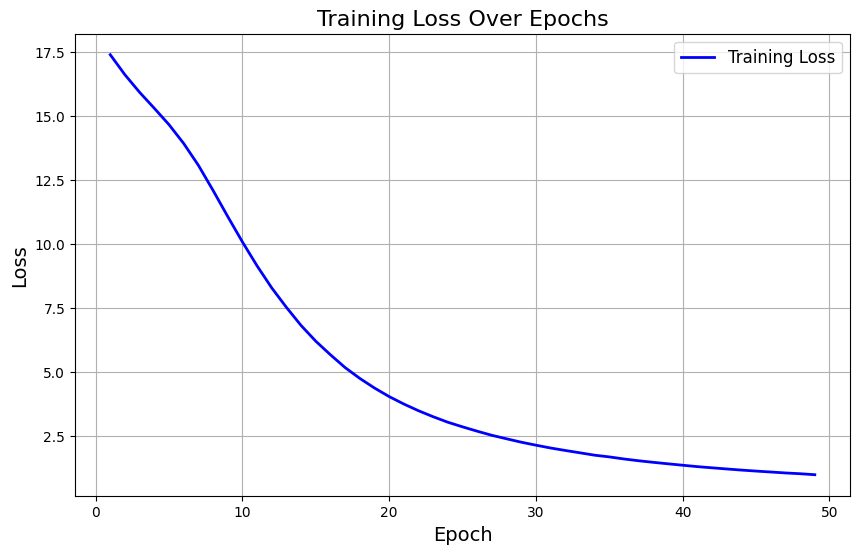

In [41]:
import matplotlib.pyplot as plt 

def plot_losses(train_losses):
    plt.figure(figsize=(10, 6))
    
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b', linewidth=2)

    plt.title('Training Loss Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.grid(True)
    plt.legend(loc='upper right', fontsize=12)

    plt.show()


plot_losses(train_losses[21:])

In [34]:
def infer(user_id, joke_id):
    model.eval()
    with torch.no_grad():
        user_id_tensor = torch.tensor([user_id], dtype=torch.long).to(device)
        joke_id_tensor = torch.tensor([joke_id], dtype=torch.long).to(device)
        prediction = model(user_id_tensor, joke_id_tensor)
        return prediction.item()

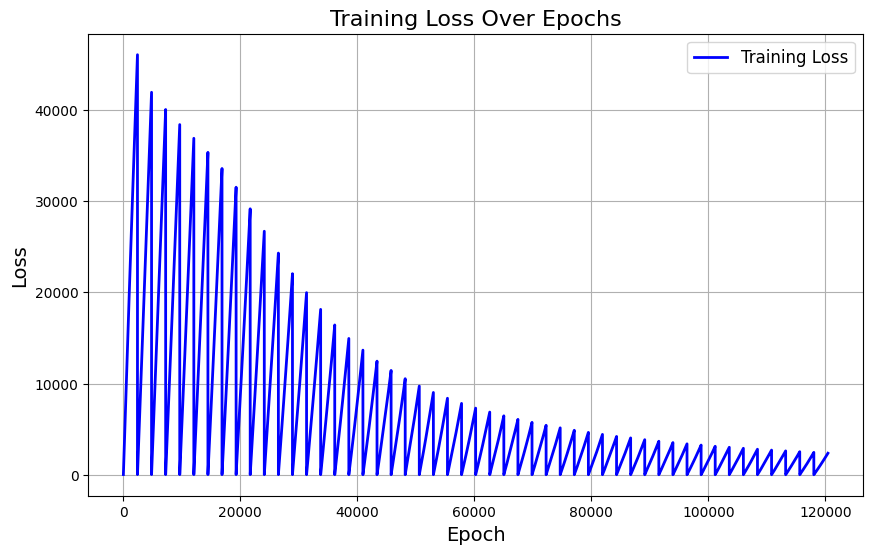

In [35]:
plot_losses(iter_losses)

In [36]:
predicted_rating = infer(1, 5)
print(predicted_rating)

-3.18289852142334


## For test dataset

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:

test_user_ids = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
test_joke_ids = torch.tensor(test_data['jokeId'].values, dtype=torch.long).to(device)
test_ratings = test_data['rating'].values  # Keep as numpy array for MSE calculation

In [39]:
def evaluate_model(model, test_user_ids, test_joke_ids, test_ratings):
    model.eval()
    with torch.no_grad():
        predictions = model(test_user_ids, test_joke_ids).detach().cpu().numpy()
    mse = mean_squared_error(test_ratings, predictions)
    print(f"Test MSE: {mse}")

In [40]:
evaluate_model(model, test_user_ids, test_joke_ids, test_ratings)

Test MSE: 26.311629068844855


In [42]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
module.user_embedding.weight 	 torch.Size([59132, 256])
module.joke_embedding.weight 	 torch.Size([140, 256])
module.fc1.weight 	 torch.Size([256, 512])
module.fc1.bias 	 torch.Size([256])
module.fc2.weight 	 torch.Size([128, 256])
module.fc2.bias 	 torch.Size([128])
module.fc3.weight 	 torch.Size([64, 128])
module.fc3.bias 	 torch.Size([64])
module.fc4.weight 	 torch.Size([1, 64])
module.fc4.bias 	 torch.Size([1])


In [46]:
torch.save(model.state_dict(), '/kaggle/working/ncf_trained_50.pth')

In [49]:
with open('/kaggle/working/ncf_50_train_losses.npy', 'wb') as f:
    np.save(f, train_losses)

with open('/kaggle/working/ncf_50_iter_losses.npy', 'wb') as f:
    np.save(f, iter_losses)